In [1]:
import qiskit
qiskit.__version__

'0.16.1'

In [2]:
# Import required package
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import qrng
from math import pi

# importing Qiskit
import qiskit
import copy
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city
from qiskit_textbook.tools import array_to_latex

# import basic plot tools
from qiskit.visualization import plot_histogram

In [3]:
#Initialize HyperParameter
MaxNsol = 300 #define MaxNsol
MaxNvar = 150 #define MaxNvar

# Nrun = 10     #define Nrun
Ngen = 200   #define Ngen  
Nsol = 5     #define Nsol
Nvar = 10     #define Nvar
Nbit = 10      #define the variable bits
theta_1 = 0.08 *pi
theta_2 = 0.001 *pi

Cg = 0.7 #define Cg
Cp = 0.9 #define Cp  
# Cw = 0.9 #define Cw

apitoken ='e26cab383f69b81aaf36106b0620f3e994afd5ef57bb861bc714b41a91dabb3c08dcc5f5f45fa395a490d1bbf0490a8b1e7caeeaa560546833ca8149d4375ef3'

In [4]:
# Create QuantumCircuit List = sol_list
# return a qc_list represent the solution value [x1, x2, x3, ...]
def Qsol_init():
    qc_list = []

    for var in range(Nvar):
        qc = QuantumCircuit(Nbit, Nbit) # Circuit with Nbit qubits and Nbit classical bits
        qr = QuantumRegister(Nbit, 'q')
        cr = ClassicalRegister(Nbit, 'c')
        qc = QuantumCircuit(qr, cr)
        qc.h(qr[0:Nbit])
        qc_list.append(qc)
    return qc_list # return a solution 有Nvar

In [5]:
# Initialize one generation with Nsol
def God_init():
    '''
    Initialize one generation with Nsol.
    ex: [[x1, x2,..., x_n], [x1, x2,..., x_n], [x1, x2,..., x_n] ...]
    '''
    God_list = []
    for sol in range(Nsol):
        God_list.append(Qsol_init())
    return God_list
God_list = God_init()

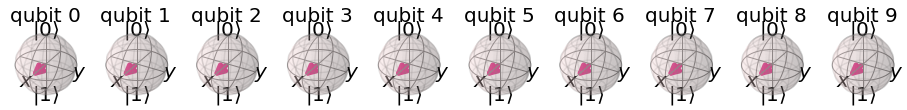

In [6]:
# Take a look at value of No.__variable in No.__sol by statevector_simulator
sol_idx = 2
var_idx = 3

backend = Aer.get_backend('statevector_simulator') 
out_state = execute(God_list[sol_idx][var_idx],backend).result().get_statevector() 
plot_bloch_multivector(out_state)

In [7]:
# sol_measure function：Measure a Q state solution to classical bits
def sol_measure(Qsol_list):
    # Use simulator to measure one solution
    Csol_list = []
    Qstate_list = []
    simulator = Aer.get_backend('qasm_simulator') # qasm_simulator is a kind of Backend

    for qc in Qsol_list:
        qc_copy = qc
        for bit in range(Nbit):
            qc_copy.measure(bit, bit)
        result = execute(qc_copy, simulator).result() # defaul shot number
        result_dict = result.to_dict()
        Qstate_list.append(result_dict['results'][0]['data']['counts'])
    for var in Qstate_list:
        Keymax = max(var, key=var.get) 
        Csol_list.append(int(Keymax, 16))
    return Csol_list

init_sol_list = sol_measure(God_list[0])
init_sol_list

[460, 582, 723, 270, 930, 843, 585, 186, 268, 441]

In [8]:
def var_measure(qc):
    '''
    var_measure function：Measure a Q state var to classical bits    
    '''
    # Use simulator to measure one solution
    simulator = Aer.get_backend('qasm_simulator') # qasm_simulator is a kind of Backend
    qc_copy = qc.copy()
    for bit in range(Nbit):
        qc_copy.measure(bit, bit)
    result = execute(qc_copy, simulator).result() # defaul shot number
    result_dict = result.to_dict()
    # print(result_dict)
    var_dict = result_dict['results'][0]['data']['counts']
    Keymax = max(var_dict, key=var_dict.get) 
    return int(Keymax, 16)

In [9]:
def FIT_cal(XX):
    '''
    This function define the OBJ function and return the fitness value.
    In this example we use the square sum of each variable.
    '''
    SUM = 0
    for var in range(Nvar):
        SUM += XX[var] * XX[var]
    return SUM

In [10]:
def best_dict_init():
    '''
    Use best_dict to storage the gbest_fitness, gbest_list, pbest_fitness, pbest_list
    '''
    best_dict = {
        "gbest_fitness": 0,
        "gbest_sol": [0 for i in range(Nvar)],
        "chromo_fitness":[0 for i in range(Nsol)],
        "chromo_list":[[0 for i in range(Nvar)] for j in range(Nsol)]
    }
    return best_dict
best_dict = best_dict_init()

In [11]:
def int_to_bin(var):
    '''
    Define a function to convert int to binary number's string.
    '''
    return format(var, f'0{Nbit}b')
# int_to_bin(12)

In [12]:
def get_Qrnd():
    '''
    Function to get random number from a Qubit in Quantum Computer.
    '''
    # IBMQ.save_account(apitoken)
    # provider = IBMQ.load_account()
    # qrng.set_provider_as_IBMQ(apitoken) #the IBMQ API token from your dashboard
    qrng.set_backend() #connect to the k qubit by quantum computer
    rnd = qrng.get_random_float(0,1) #generate a random N bit float between 0 to 1
    return rnd
# rnd = get_Qrnd()
# rnd

In [13]:
def get_bin_sol(sol_list):
    '''
    Define a function to convert a list of decimal solution to binary variable in string type.
    '''
    bin_list = []
    for var in sol_list:
        bin_list.append(int_to_bin(var))
    return bin_list

In [14]:
def get_ab_list(Qsol):
    '''
    This function will return a list with ai bi state in Qsol_list
    '''
    backend = Aer.get_backend('statevector_simulator') 
    ab_list = []
    for var in range(Nvar):
        ab_var = []
        for bit in range(Nbit):
            qc_tmp = Qsol[var].copy()
            # 從variable 的最右方的bit 開始量測
            collapse_bit = [i for i in range(Nbit) if i != bit]
            qc_tmp.measure(collapse_bit, collapse_bit)
            out_state = execute(qc_tmp,backend).result().get_statevector()
            # ab_bit = out_state[out_state>0].tolist()
            out_state_complex = out_state.tolist()
            out_state_real = [out_state_complex[i].real for i in range(len(out_state_complex))]
            ab_bit = [state for state in out_state_real if state != float(0)]
            # print(ab_bit) # if need to check the amplitude

            # if there is a the extreme condition! 
            if len(ab_bit) < 2:
                print("\n +-1 in the state_list!!")
                for i in range(len(out_state_real)):
                    if (out_state_real[i] != float(0)):
                        if ((int(int_to_bin(i)[Nbit - 1 - bit]) == 1)):
                            ab_bit = [0, 1]
                        elif (int(int_to_bin(i)[Nbit - 1 - bit]) == 0):
                            ab_bit = [1, 0]
            ab_var.append(ab_bit)
        ab_list.append(ab_var)
    return ab_list
# get_ab_list(God_list)


In [ ]:
def sol_update(sol):
    '''
    Get a solution with Nvar from Qsol_list.
    '''
    sol_list = []
    for var in range(Nvar):
            variable = (var_measure(God_list[sol][var]))
            sol_list.append(variable)
    return sol_list


In [15]:
def chromo_init(sol):
    '''
    Initialize one solution list for Nvar from Random Quantumn state list.
    初始化單條染色體（Sol_i）
    '''
    return sol_update(sol)
sol_test = chromo_init(0)
sol_test

NameError: name 'sol_update' is not defined

In [17]:
def GA_update(sol, sol_list, sol_fitness):
    '''
    This function update the gbest and pbest for "Sol_i" recorded in best_dict.
    '''
    global best_dict
    global God_list
    
    curr_bin_sol = get_bin_sol(sol_list)
    # if curr_sol is better(in this case: smaller)

    if sol_fitness >= best_dict["gbest_fitness"]:
        # update the best_dict[gbest]
        print('Get Better global best!\n')
        best_dict["gbest_fitness"] = sol_fitness
        best_dict["gbest_sol"] = sol_list
    
    # Compare for chromo_fitness
    if sol_fitness >= best_dict["chromo_fitness"][sol]:
        print(f'Get Better pbest sol_{sol} fitness: {sol_fitness}')
        print(f'Original pBest_fitness: {best_dict["chromo_fitness"][sol]}')
        
        # get the ai, bi of God_list[Qsol]
        Qpbest_ab = get_ab_list(God_list[sol])
        # get the binary sol_list to compare
        chromosome_bin_sol = get_bin_sol(best_dict["chromo_list"][sol])

        for var in range(Nvar):
            for bit in range(Nbit):
                # a, b要從尾巴取                
                a = Qpbest_ab[var][Nbit - 1 - bit][0]
                b = Qpbest_ab[var][Nbit - 1 - bit][1]
                if int(chromosome_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit] == 0):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(chromosome_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 0)):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    
                if (int(chromosome_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit]) == 1):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(chromosome_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 1)):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if ((a*b).real > 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif ((a*b).real < 0):
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif ((a*b).real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
        best_dict["chromo_fitness"][sol] = sol_fitness
        best_dict["chromo_list"][sol] = sol_list
        print(f'Uodate pBest_fitness: {best_dict["chromo_fitness"][sol]}')
    
    elif sol_fitness < best_dict["chromo_fitness"][sol]:
        # get the ai, bi of God_list[Qsol]
        Qpbest_ab = get_ab_list(God_list[sol])
        # get the binary sol_list to compare
        chromosome_bin_sol = get_bin_sol(best_dict["chromo_list"][sol])
        for var in range(Nvar):
            for bit in range(Nbit):
                # a, b要從尾巴取
                a = Qpbest_ab[var][Nbit - 1 - bit][0]
                b = Qpbest_ab[var][Nbit - 1 - bit][1]
                if (int(chromosome_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit] == 0)):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a == 0 or b == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

                if int(chromosome_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 0):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_1
                    if (a*b).real > 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    
                if (int(chromosome_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit]) == 1):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_1
                    if (a*b).real > 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(chromosome_bin_sol[var][bit]) == 1 and int(curr_bin_sol[var][bit]) == 1):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if ((a*b).real > 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif ((a*b).real < 0):
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif ((a*b).real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

    return God_list

In [36]:
# main function
God_list = God_init()
best_dict = best_dict_init()

for sol in range(Nsol):
    sol_list = chromo_init(sol)
    sol_fitness = FIT_cal(sol_list)
    print(f"Initialize sol_{sol}:", sol_list)
    print("sol_fitness: ", sol_fitness)
    GA_update(sol, sol_list, sol_fitness)

print('Global best fitness: {}'.format(best_dict['gbest_fitness']))
print('Global best solution: {}'.format(best_dict['gbest_sol']))

for gen in range(Ngen):
    print(f'=============== Generation_{gen} ===============')
    for sol in range(Nsol):
        print(f'----- sol_{sol} -----')
        sol_list = sol_update(sol)
        sol_fitness = FIT_cal(sol_list)
        print('sol_fitness: {}'.format(sol_fitness))
        print('sol_list: ',sol_list)
        GA_update(sol, sol_list, sol_fitness)
        print('Global best fitness: {}'.format(best_dict['gbest_fitness']))
    
    print('Global best fitness: {}'.format(best_dict['gbest_fitness']))
    print('Global best solution: {}'.format(best_dict['gbest_sol']))
    

Initialize sol_0: [315, 277, 279, 505, 957, 288, 626, 257, 79, 1012]
sol_fitness:  2995923
Get Better global best!

Get Better pbest sol_0 fitness: 2995923
Original pBest_fitness: 0
Uodate pBest_fitness: 2995923
Initialize sol_1: [652, 594, 298, 361, 648, 260, 472, 272, 468, 683]
sol_fitness:  2466850
Get Better pbest sol_1 fitness: 2466850
Original pBest_fitness: 0
Uodate pBest_fitness: 2466850
Initialize sol_2: [600, 834, 985, 593, 634, 475, 964, 584, 467, 596]
sol_fitness:  4848668
Get Better global best!

Get Better pbest sol_2 fitness: 4848668
Original pBest_fitness: 0
Uodate pBest_fitness: 4848668
Initialize sol_3: [392, 847, 51, 627, 342, 283, 537, 337, 566, 336]
sol_fitness:  2299046
Get Better pbest sol_3 fitness: 2299046
Original pBest_fitness: 0
Uodate pBest_fitness: 2299046
Initialize sol_4: [274, 601, 811, 348, 343, 433, 392, 736, 574, 403]
sol_fitness:  2707485
Get Better pbest sol_4 fitness: 2707485
Original pBest_fitness: 0
Uodate pBest_fitness: 2707485
Global best fitn